# Ameriflux and Earth Engine Joined EDA

Notebook to look at the EDA for Ameriflux and Earth Engine data

In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import re
import seaborn as sns
import datetime as dt
%matplotlib inline

/Users/justineschabel/my_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Abbreviations:
* AF = Ameriflux 
* EE = Earth Engine

## Extract the Ameriflux Sites 

In [2]:
# Filter to get only the necessary sites
potential_sites_file = open('data/potential_sites2.json')
potential_sites_dict = json.load(potential_sites_file)
potential_site_names = list(potential_sites_dict.keys())

all_sites_df = pd.read_csv("data/ameriflux_lulc_lat_long.csv")

wanted_site_and_info = all_sites_df[all_sites_df['SITE_ID'].isin(potential_site_names)].drop_duplicates()
# wanted_site_and_info.to_csv('data/wanted_sites.csv')

In [3]:
print("Number of ameriflux sites: ", len(wanted_site_and_info["SITE_ID"].unique()))

Number of ameriflux sites:  57


## Load the Elevation data from Earth Engine
This dataset is from the USGS 10m dataset

In [4]:
# Combine with earth engine's elevation data and get difference in elevations
ee_elevation = pd.read_csv("data/final_elev_export.csv").drop_duplicates()
print("Number of elevation results from earth engine: ", len(ee_elevation.index))
ee_elevation.head()

Number of elevation results from earth engine:  57


,SITE_ID,elevation
0,US-PFa,472.534573
1,US-Syv,540.559114
2,US-Bi1,-3.707723
3,US-Bi2,-5.102190
4,US-CS1,334.475391


## Merge the elevation dataset and the Ameriflux Dataset

We should validate and compare the elevation from the ameriflux dataset to the one from earth engine 

In [5]:
# TODO: look at weird dup happening here
wanted_site_and_info = wanted_site_and_info.merge(ee_elevation).rename(columns={"ELEVATION": "ameriflux_elevation", 
                                                                                "elevation": "ee_elevation"}).drop_duplicates()
wanted_site_and_info['elevation_diff'] = abs(wanted_site_and_info['ameriflux_elevation'] - wanted_site_and_info['ee_elevation'])
wanted_site_and_info = wanted_site_and_info[wanted_site_and_info.columns.drop(list(wanted_site_and_info.filter(regex='Unnamed:')))].drop_duplicates()
wanted_site_and_info.head()

,SITE_ID,LULC,LATITUDE,LONGITUDE,ameriflux_elevation,ee_elevation,elevation_diff
0,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723
1,US-Bi2,CRO,38.1091,-121.5351,-5.0,-5.102190,0.102190
2,US-BZF,WET,64.7013,-148.3121,95.0,121.559183,26.559183
3,US-BZo,WET,64.6936,-148.3300,100.0,121.369157,21.369157
4,US-BZS,ENF,64.6963,-148.3235,100.0,122.117881,22.117881


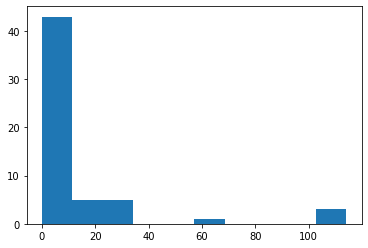

In [6]:
# Histogram of elevation difference at a given site between AF and EE data
elev_diff_hist = plt.hist(wanted_site_and_info['elevation_diff'])

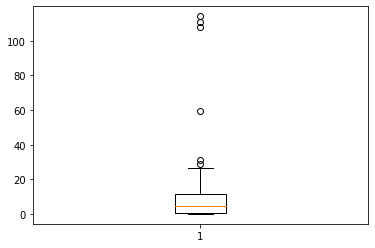

In [7]:
boxplot = plt.boxplot(wanted_site_and_info['elevation_diff'])

## Load Dynamic World Data

This data was extracted according to the following quarters:
* 1: Dec - Feb
* 2: Mar - May
* 3: Jun - Aug
* 4: Sep - Nov

In [8]:
# read in dynamic world probabilities
ee_probs = pd.read_csv("data/final_dw_export.csv")

In [9]:
ee_probs.describe()

,water_mean,trees_mean,grass_mean,flooded_vegetation_mean,crops_mean,shrub_and_scrub_mean,built_mean,bare_mean,snow_and_ice_mean,label_mean
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000
mean,0.050013,0.220001,0.096658,0.064157,0.140814,0.131474,0.038429,0.084007,0.174407,3.982572
std,0.038282,0.232134,0.094457,0.102163,0.167935,0.113549,0.012006,0.054463,0.225322,2.249099
min,0.021566,0.022693,0.022111,0.019285,0.023676,0.017957,0.022829,0.022761,0.022630,0.034829
25%,0.034076,0.039288,0.037750,0.029917,0.033582,0.045953,0.032630,0.042548,0.033416,2.081105
50%,0.041592,0.097397,0.057690,0.034160,0.048286,0.088857,0.035841,0.068875,0.041107,3.900055
75%,0.049749,0.374903,0.110224,0.043711,0.184334,0.189574,0.040703,0.105417,0.255821,5.379443
max,0.489441,0.757124,0.583722,0.668777,0.666294,0.557853,0.188935,0.396346,0.732424,8.000000


In [10]:
# Create a new variable for label
# We'll use argmax instead of mean, since there's no relationship between the labels 0-8
ee_probs["label_argmax"] = ee_probs[["water_mean", 
         "trees_mean",  
         "grass_mean", 
         "flooded_vegetation_mean", 
         "crops_mean", 
         "shrub_and_scrub_mean", 
         "built_mean", 
         "bare_mean", 
         "snow_and_ice_mean"]].astype(float).idxmax(axis=1)

# Add a number for the numeric representation of the label_argmax
ee_probs['label_argmax_numeric'] = ee_probs["label_argmax"].replace(["water_mean", 
         "trees_mean",  
         "grass_mean", 
         "flooded_vegetation_mean", 
         "crops_mean", 
         "shrub_and_scrub_mean", 
         "built_mean", 
         "bare_mean", 
         "snow_and_ice_mean"],
                        [0, 1,2,3,4,5,6,7,8])

In [11]:
# Add some helpful date-types 
ee_probs['START_DATE'] = pd.to_datetime(ee_probs['START_DATE'], errors='coerce')
ee_probs['quarter'] = ee_probs['START_DATE'].dt.to_period('Q-NOV')
ee_probs['year'] = ee_probs['quarter'].dt.year
ee_probs['quarter_val'] = ee_probs.quarter.dt.quarter

In [12]:
print("Rows in dynamic world dataset: ", len(ee_probs.index))
ee_probs.sample(20)

Rows in dynamic world dataset:  882


,SITE_ID,START_DATE,END_DATE,water_mean,trees_mean,grass_mean,flooded_vegetation_mean,crops_mean,shrub_and_scrub_mean,built_mean,bare_mean,snow_and_ice_mean,label_mean,EXTENDED_END_DATE,label_argmax,label_argmax_numeric,quarter,year,quarter_val
468,US-Los,2020-03-02,2020-5-31,0.043424,0.044839,0.061561,0.032644,0.031026,0.243742,0.033263,0.204900,0.304562,6.339602,NaN,snow_and_ice_mean,8,2020Q2,2020,2
426,US-Prr,2016-03-02,2016-5-31,0.041758,0.046302,0.115467,0.033520,0.026490,0.146342,0.032035,0.086025,0.472024,7.000000,NaN,snow_and_ice_mean,8,2016Q2,2016,2
630,US-ICh,2016-03-02,2016-5-31,0.049633,0.027752,0.032488,0.032022,0.031290,0.019252,0.032962,0.108652,0.665912,8.000000,NaN,snow_and_ice_mean,8,2016Q2,2016,2
130,US-BZo,2020-12-01,2021-3-1,0.032115,0.024789,0.026037,0.027232,0.029884,0.026129,0.046957,0.073018,0.713804,8.000000,NaN,snow_and_ice_mean,8,2021Q1,2021,1
813,US-Myb,2018-06-01,2018-8-31,0.120390,0.125783,0.063130,0.400529,0.051622,0.077475,0.049711,0.053426,0.057894,2.997812,NaN,flooded_vegetation_mean,3,2018Q3,2018,3
694,US-Ro5,2020-03-02,2020-5-31,0.054525,0.031343,0.049539,0.036893,0.547650,0.043105,0.029760,0.091115,0.116031,4.500000,NaN,crops_mean,4,2020Q2,2020,2
733,US-Tw4,2018-12-01,2019-3-1,0.059120,0.101867,0.157428,0.078242,0.188754,0.238191,0.038559,0.103645,0.034151,4.013059,NaN,shrub_and_scrub_mean,5,2019Q1,2019,1
246,US-Me2,2018-03-02,2018-5-31,0.034706,0.562567,0.036027,0.027849,0.034286,0.071708,0.037571,0.037769,0.157481,2.750000,NaN,trees_mean,1,2018Q2,2018,2
371,US-Rpf,2017-09-01,2017-11-30,0.039558,0.219949,0.072993,0.035969,0.037494,0.188952,0.044198,0.102920,0.257929,4.600000,NaN,snow_and_ice_mean,8,2017Q4,2017,4
12,US-Var,2016-09-01,2016-11-30,0.025826,0.053354,0.264068,0.031527,0.099578,0.285243,0.038789,0.158907,0.042668,3.500000,NaN,shrub_and_scrub_mean,5,2016Q4,2016,4


In [13]:
ee_probs.isnull().sum(axis=0)

SITE_ID                      0
START_DATE                   0
END_DATE                     0
water_mean                   0
trees_mean                   0
grass_mean                   0
flooded_vegetation_mean      0
crops_mean                   0
shrub_and_scrub_mean         0
built_mean                   0
bare_mean                    0
snow_and_ice_mean            0
label_mean                   0
EXTENDED_END_DATE          846
label_argmax                 0
label_argmax_numeric         0
quarter                      0
year                         0
quarter_val                  0
dtype: int64

In [14]:
ee_probs.to_csv("data/enhanced_ee_probs.csv")

## Merge Dyanamic World with Ameriflux and Elevation for some EDA

In [15]:
# Merge with Ameriflux
ee_probs_and_ameriflux = wanted_site_and_info.merge(ee_probs, on="SITE_ID", how="inner")
print("Length after merging ee_probs and ameriflux", len(ee_probs_and_ameriflux.index))
ee_probs_and_ameriflux.head() # TODO: REVISIT TO CHECK FOR DUPLICATES OR LOST DATA

Length after merging ee_probs and ameriflux 882


,SITE_ID,LULC,LATITUDE,LONGITUDE,ameriflux_elevation,ee_elevation,elevation_diff,START_DATE,END_DATE,water_mean,...,built_mean,bare_mean,snow_and_ice_mean,label_mean,EXTENDED_END_DATE,label_argmax,label_argmax_numeric,quarter,year,quarter_val
0,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,2016-09-01,2016-11-30,0.027617,...,0.039467,0.025610,0.032171,4.000000,NaN,crops_mean,4,2016Q4,2016,4
1,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,2020-03-02,2020-5-31,0.028448,...,0.044063,0.027084,0.042844,2.917157,NaN,crops_mean,4,2020Q2,2020,2
2,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,2016-06-01,2016-8-31,0.028688,...,0.035063,0.042661,0.037578,3.900083,NaN,crops_mean,4,2016Q3,2016,3
3,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,2019-09-01,2019-11-30,0.029993,...,0.040609,0.025994,0.041344,3.187387,NaN,crops_mean,4,2019Q4,2019,4
4,US-Bi1,CRO,38.0992,-121.4993,-2.7,-3.707723,1.007723,2019-06-01,2019-8-31,0.031103,...,0.043248,0.046089,0.042297,3.141624,NaN,crops_mean,4,2019Q3,2019,3


In [16]:
# Exporting EE_Probs to CSV
ee_probs_and_ameriflux.to_csv('data/combined_eda/combined_ee_af_elevation.csv')

In [17]:
### FOR THOSE RUNNING FROM GITHUB --> RUN FROM HERE
ee_probs_and_ameriflux = pd.read_csv('data/combined_eda/combined_ee_af_elevation.csv')

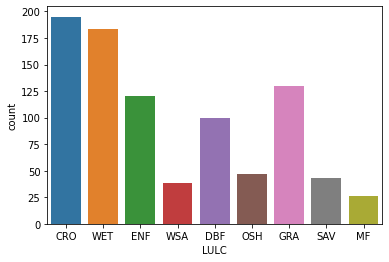

In [18]:
landclass_countplot = sns.countplot(x="LULC", data=ee_probs_and_ameriflux)

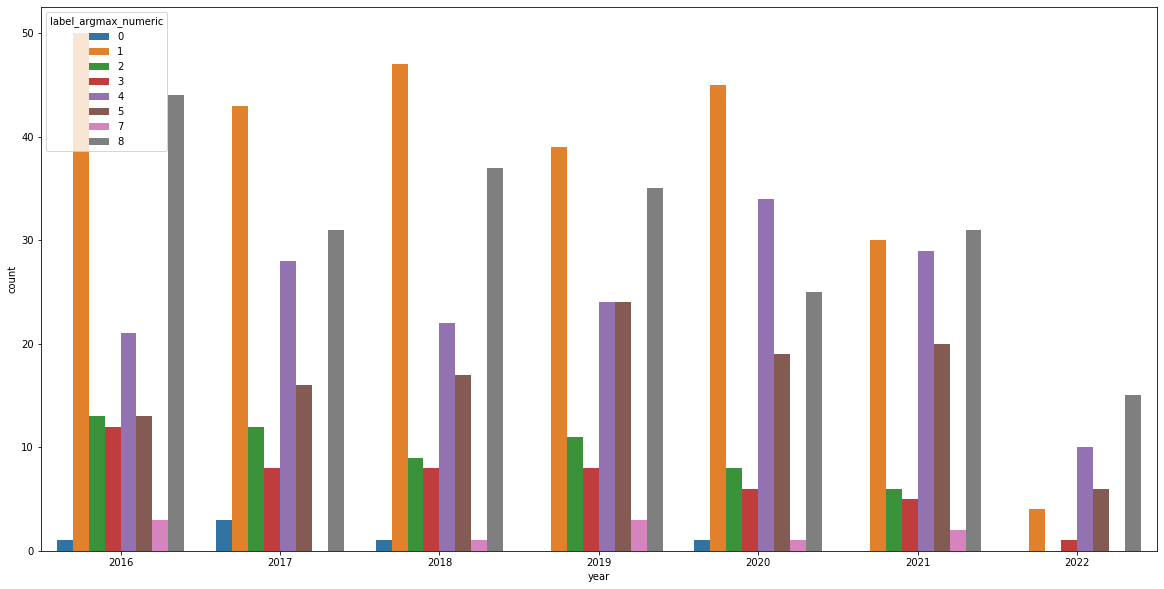

In [19]:
plt.figure(figsize = (20,10))
p = sns.countplot(x="year", hue="label_argmax_numeric", data=ee_probs_and_ameriflux)

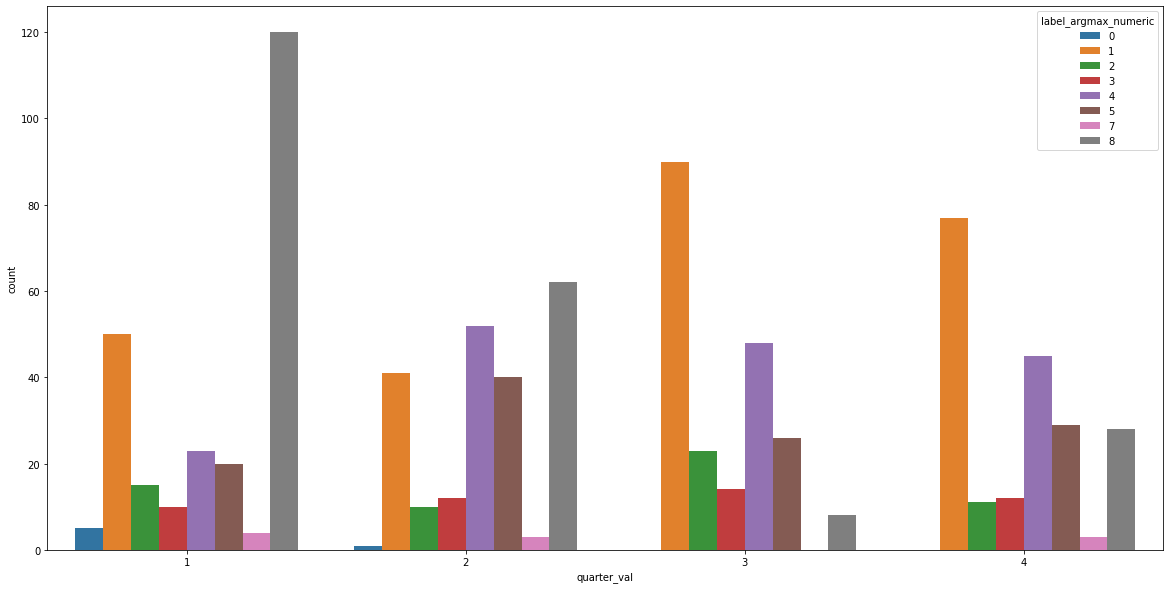

In [20]:
# labels rounded by quarter
plt.figure(figsize = (20,10))
p = sns.countplot(x="quarter_val", hue="label_argmax_numeric", data=ee_probs_and_ameriflux)

/var/folders/l5/htp998mx75n52pzs2kd2j9v00000gn/T/ipykernel_29767/2339632488.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


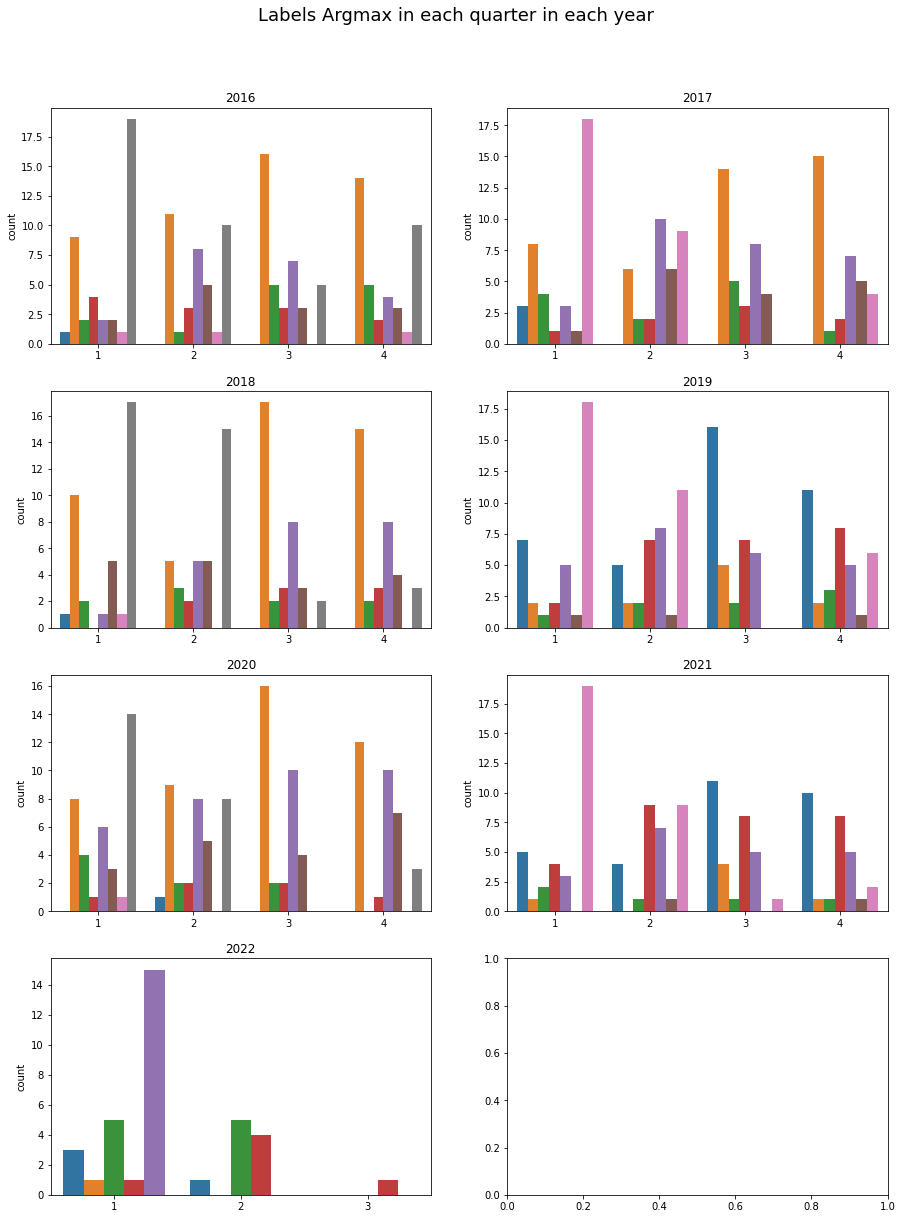

In [21]:
years = ee_probs_and_ameriflux.year.unique()
years.sort()
# labels rounded by quarter & year
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle("Labels Argmax in each quarter in each year", fontsize=18, y=0.95)
for y, ax in zip(years, axs.ravel()):
    sns.countplot(x="quarter_val", hue="label_argmax_numeric", data=ee_probs_and_ameriflux[ee_probs_and_ameriflux['year'] == y], ax=ax)
    ax.set_title(y)
    ax.get_legend().remove()
    ax.set_xlabel("")
    if y == '2016':
        ax.legend(loc='upper left')
fig.show()

## Load Earth Engine Mod15A Dataset
This dataset has weekly values for leaf area index and photosynthetically active radiation

In [22]:
ee_mod = pd.read_csv("data/final_mod_export.csv")
ee_mod['DATE'] = pd.to_datetime(ee_mod['DATE'], errors='coerce')

print("Number of rows in Earth Engine Mod15 data export: ", len(ee_mod.index))

# convert to daily
ee_mod = ee_mod.set_index('DATE').groupby('SITE_ID').resample('D').mean().ffill().reset_index()

print("Number of rows in Earth Engine Mod15 data export once converted to daily: ", len(ee_mod.index))
ee_mod.head()

Number of rows in Earth Engine Mod15 data export:  25253
Number of rows in Earth Engine Mod15 data export once converted to daily:  196442


,SITE_ID,DATE,Fpar_500m,Lai_500m
0,US-BZF,2011-01-01,255.0,255.0
1,US-BZF,2011-01-02,255.0,255.0
2,US-BZF,2011-01-03,255.0,255.0
3,US-BZF,2011-01-04,255.0,255.0
4,US-BZF,2011-01-05,255.0,255.0


In [23]:
ee_mod.isnull().sum(axis=0)

SITE_ID      0
DATE         0
Fpar_500m    0
Lai_500m     0
dtype: int64

In [24]:
print(min(ee_mod['DATE']), max(ee_mod['DATE']))

2000-02-18 00:00:00 2022-07-20 00:00:00


In [25]:
# code to get first day of the week for ee_mod, as the weeks are irregular
# def get_first_day_of_week(dte):
#     return dte - dt.timedelta(days=dte.isoweekday() % 7) 

# ee_mod['first_day'] = ee_mod['DATE'].apply(get_first_day_of_week)
# ee_mod['week'] = ee_mod['DATE'].dt.to_period('W-SAT').apply(lambda r: r.start_time)-dt.timedelta(days=1)

## Load Earth Engine GRIDMET Dataset 
This dataset has daily values for min and max temperature, vapor pressure, and shortwave radiation

In [26]:
ee_gridmet = pd.read_csv("data/final_gridmet_export.csv").drop(['system_index', '.geo'], axis=1)
ee_gridmet['DATE'] = pd.to_datetime(ee_gridmet['DATE'], errors='coerce')
ee_gridmet['quarter'] = ee_gridmet['DATE'].dt.to_period('Q-NOV')
ee_gridmet['quarter_val'] = ee_gridmet.quarter.dt.quarter
ee_gridmet['year'] = ee_gridmet['DATE'].dt.year

print("Number of rows in Earth Engine GRIDMET export: ", len(ee_gridmet.index))

ee_gridmet.head()

Number of rows in Earth Engine GRIDMET export:  160879


,DATE_STR,DATE,SITE_ID,srad,tmmn,tmmx,vpd,quarter,quarter_val,year
0,19980101,1998-01-02,US-WCr,77.465156,261.014840,271.551632,0.046213,1998Q1,1,1998
1,19980102,1998-01-03,US-WCr,77.017307,266.355203,274.631221,0.040514,1998Q1,1,1998
2,19980103,1998-01-04,US-WCr,60.919844,261.384683,271.371212,0.072257,1998Q1,1,1998
3,19980104,1998-01-05,US-WCr,57.753926,260.144809,268.990932,0.045163,1998Q1,1,1998
4,19980105,1998-01-06,US-WCr,30.426480,266.905054,272.250911,0.054273,1998Q1,1,1998


In [27]:
print(min(ee_gridmet['DATE']), max(ee_gridmet['DATE']))

1998-01-01 00:00:00 2022-07-27 00:00:00


In [28]:
ee_gridmet.isnull().sum(axis=0)

DATE_STR        0
DATE            0
SITE_ID         0
srad            0
tmmn           50
tmmx            0
vpd             0
quarter         0
quarter_val     0
year            0
dtype: int64

In [29]:
my_range = pd.date_range(
  start="1998-01-01", end="2022-07-27", freq='D')
 
print(my_range.difference(ee_gridmet['DATE']))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


## Merge Gridmet and MOD15

In [30]:
gridmet_and_mod_merged = ee_gridmet.merge(ee_mod, on=["SITE_ID", "DATE"], how="left")
print("Number of rows in GRIDMET MOD merge: ", len(gridmet_and_mod_merged.index))

Number of rows in GRIDMET MOD merge:  160879


In [31]:
gridmet_and_mod_merged.describe()

,DATE_STR,srad,tmmn,tmmx,vpd,quarter_val,year,Fpar_500m,Lai_500m
count,1.608790e+05,160879.000000,160829.000000,160879.000000,160879.000000,160879.000000,160879.000000,159834.000000,159834.000000
mean,2.012611e+07,194.955840,278.530420,291.655928,0.892274,2.491612,2012.544875,40.525578,11.581336
std,5.786305e+04,93.128582,10.603956,12.118146,0.788043,1.113016,5.787027,23.843251,12.017357
min,1.998010e+07,0.000000,237.148430,246.064890,0.000000,1.000000,1998.000000,0.000000,0.000000
25%,2.008103e+07,111.958581,272.100006,283.799988,0.280000,2.000000,2008.000000,21.540587,3.063106
50%,2.013102e+07,192.269058,279.852230,293.500596,0.689071,2.000000,2013.000000,38.386638,7.792007
75%,2.017111e+07,273.399994,286.406648,301.167347,1.256980,3.000000,2017.000000,58.495525,15.674532
max,2.022073e+07,384.725006,713.000000,319.173462,5.185182,4.000000,2022.000000,99.584841,68.996555


## Merge all datasets

In [32]:
merged = gridmet_and_mod_merged.merge(wanted_site_and_info, on="SITE_ID", how="left")

In [33]:
merged.columns

Index(['DATE_STR', 'DATE', 'SITE_ID', 'srad', 'tmmn', 'tmmx', 'vpd', 'quarter',
       'quarter_val', 'year', 'Fpar_500m', 'Lai_500m', 'LULC', 'LATITUDE',
       'LONGITUDE', 'ameriflux_elevation', 'ee_elevation', 'elevation_diff'],
      dtype='object')

In [34]:
ee_probs = pd.read_csv("data/enhanced_ee_probs.csv")

In [35]:
ee_probs.columns

Index(['Unnamed: 0', 'SITE_ID', 'START_DATE', 'END_DATE', 'water_mean',
       'trees_mean', 'grass_mean', 'flooded_vegetation_mean', 'crops_mean',
       'shrub_and_scrub_mean', 'built_mean', 'bare_mean', 'snow_and_ice_mean',
       'label_mean', 'EXTENDED_END_DATE', 'label_argmax',
       'label_argmax_numeric', 'quarter', 'year', 'quarter_val'],
      dtype='object')

In [36]:
ee_probs['DATE'] =  pd.to_datetime(ee_probs['START_DATE'], errors='coerce')
ee_probs = ee_probs.set_index('DATE').groupby('SITE_ID').resample('D').mean().ffill().reset_index()

In [37]:
ee_probs.columns

Index(['SITE_ID', 'DATE', 'Unnamed: 0', 'water_mean', 'trees_mean',
       'grass_mean', 'flooded_vegetation_mean', 'crops_mean',
       'shrub_and_scrub_mean', 'built_mean', 'bare_mean', 'snow_and_ice_mean',
       'label_mean', 'label_argmax_numeric', 'year', 'quarter_val'],
      dtype='object')

In [38]:
combined = merged.merge(ee_probs, on=["SITE_ID", "DATE"], how="left")

In [39]:
combined.columns

Index(['DATE_STR', 'DATE', 'SITE_ID', 'srad', 'tmmn', 'tmmx', 'vpd', 'quarter',
       'quarter_val_x', 'year_x', 'Fpar_500m', 'Lai_500m', 'LULC', 'LATITUDE',
       'LONGITUDE', 'ameriflux_elevation', 'ee_elevation', 'elevation_diff',
       'Unnamed: 0', 'water_mean', 'trees_mean', 'grass_mean',
       'flooded_vegetation_mean', 'crops_mean', 'shrub_and_scrub_mean',
       'built_mean', 'bare_mean', 'snow_and_ice_mean', 'label_mean',
       'label_argmax_numeric', 'year_y', 'quarter_val_y'],
      dtype='object')

In [40]:
print("rows after upsampling: ", len(combined.index))

rows after upsampling:  160879


In [41]:
combined.describe()

,DATE_STR,srad,tmmn,tmmx,vpd,quarter_val_x,year_x,Fpar_500m,Lai_500m,LATITUDE,...,flooded_vegetation_mean,crops_mean,shrub_and_scrub_mean,built_mean,bare_mean,snow_and_ice_mean,label_mean,label_argmax_numeric,year_y,quarter_val_y
count,1.608790e+05,160879.000000,160829.000000,160879.000000,160879.000000,160879.000000,160879.000000,159834.000000,159834.000000,160879.000000,...,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000
mean,2.012611e+07,194.955840,278.530420,291.655928,0.892274,2.491612,2012.544875,40.525578,11.581336,40.248401,...,0.070408,0.171010,0.133919,0.038686,0.081765,0.111962,3.478397,3.484070,2018.449554,2.458651
std,5.786305e+04,93.128582,10.603956,12.118146,0.788043,1.113016,5.787027,23.843251,12.017357,4.981349,...,0.115547,0.180027,0.117507,0.012946,0.058533,0.167665,1.943966,2.349028,1.728376,1.118117
min,1.998010e+07,0.000000,237.148430,246.064890,0.000000,1.000000,1998.000000,0.000000,0.000000,31.201000,...,0.019285,0.023676,0.018500,0.022829,0.022761,0.022630,0.034829,0.000000,2016.000000,1.000000
25%,2.008103e+07,111.958581,272.100006,283.799988,0.280000,2.000000,2008.000000,21.540587,3.063106,38.102700,...,0.029200,0.038088,0.048053,0.032631,0.039686,0.032985,1.888889,1.000000,2017.000000,1.000000
50%,2.013102e+07,192.269058,279.852230,293.500596,0.689071,2.000000,2013.000000,38.386638,7.792007,41.164900,...,0.033357,0.067819,0.087473,0.036256,0.059228,0.038174,3.395195,4.000000,2018.000000,2.000000
75%,2.017111e+07,273.399994,286.406648,301.167347,1.256980,3.000000,2017.000000,58.495525,15.674532,44.714300,...,0.043744,0.264940,0.183977,0.040783,0.104379,0.060868,4.778155,5.000000,2020.000000,3.000000
max,2.022073e+07,384.725006,713.000000,319.173462,5.185182,4.000000,2022.000000,99.584841,68.996555,46.242000,...,0.668777,0.666294,0.557853,0.188935,0.396346,0.725588,8.000000,8.000000,2022.000000,4.000000


In [42]:
combined.isnull().sum(axis=0)

DATE_STR                        0
DATE                            0
SITE_ID                         0
srad                            0
tmmn                           50
tmmx                            0
vpd                             0
quarter                         0
quarter_val_x                   0
year_x                          0
Fpar_500m                    1045
Lai_500m                     1045
LULC                            0
LATITUDE                        0
LONGITUDE                       0
ameriflux_elevation             0
ee_elevation                    0
elevation_diff                  0
Unnamed: 0                 102183
water_mean                 102183
trees_mean                 102183
grass_mean                 102183
flooded_vegetation_mean    102183
crops_mean                 102183
shrub_and_scrub_mean       102183
built_mean                 102183
bare_mean                  102183
snow_and_ice_mean          102183
label_mean                 102183
label_argmax_n

In [43]:
# Exporting combined to CSV
combined.to_csv('data/combined_eda/combined.csv')

In [44]:
### FOR THOSE RUNNING FROM GITHUB --> RUN FROM HERE
combined = pd.read_csv('data/combined_eda/combined.csv')

# Exploratory Data Analysis (EDA)

Exploring the combined AmeriFlux & EE data

Regarding Label, the values for land classes in the dynamic world dataset are defined [here](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#bands)

| Value | Description        |
|-------|--------------------|
| 0     | water              |
| 1     | trees              |
| 2     | grass              |
| 3     | flooded_vegetation |
| 4     | crops              |
| 5     | shrub_and_scrub    |
| 6     | built              |
| 7     | bare               |
| 8     | snow_and_ice       |

LULC Labels from AmeriFlux ([link](https://fluxnet.org/data/badm-data-templates/igbp-classification/)):

| label | name                                | description                                                                                                                                                                                                                                         |
|-------|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BSV   | Barren Sparse Vegetation            | Lands exposed soil, sand, or rocks and has less than 10% vegetative cover during any time of the year.                                                                                                                                              |
| CRO   | Croplands                           | Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.                  |
| CSH   | Closed Shrublands                   | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover >60%. The shrub foliage can be either evergreen or deciduous.                                                                                                       |
| CVM   | Cropland/Natural Vegetation Mosaics | Lands with a mosaic of croplands, forest, shrublands, and grasslands in which no one component comprises more than 60% of the landscape.                                                                                                            |
| DBF   | Deciduous Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                           |
| DNF   | Deciduous Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of seasonal needleleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                 |
| EBF   | Evergreen Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees and shrubs remain green year round. Canopy is never without green foliage.                                                            |
| ENF   | Evergreen Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.                                                                         |
| GRA   | Grasslands                          | Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water. |
| MF    | Mixed Forests                       | Lands dominated by trees with a percent cover >60% and height exceeding 2 meters. Consists of tree communities with interspersed mixtures or mosaics of the other four forest types. None of the forest types exceeds 60% of landscape.             |
| OSH   | Open Shrublands                     | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.                                                                                             |
| SAV   | Savannas                            | Lands with herbaceous and other understory systems, and with forest canopy cover between 10-30%. The forest cover height exceeds 2 meters.                                                                                                          |
| SNO   | Snow and Ice                        | Lands under snow/ice cover most of the year.                                                                                                                                                                                                        |
| URB   | Urban and Built-Up Lands            | Land covered by buildings and other man-made structures.                                                                                                                                                                                            |
| WAT   | Water Bodies                        |                                                                                                                                                                                                                                                     |
| WET   | Permanent Wetland                   | Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh water.                                                                      |
| WSA   | Woody Savannas                      | Lands with herbaceous and other understory systems, and with forest canopy cover between 30-60%. The forest cover height exceeds 2 meters.                                                                                                          |

In [45]:
merged.isnull().sum(axis=0)

DATE_STR                  0
DATE                      0
SITE_ID                   0
srad                      0
tmmn                     50
tmmx                      0
vpd                       0
quarter                   0
quarter_val               0
year                      0
Fpar_500m              1045
Lai_500m               1045
LULC                      0
LATITUDE                  0
LONGITUDE                 0
ameriflux_elevation       0
ee_elevation              0
elevation_diff            0
dtype: int64

In [46]:
combined_stats = combined.describe()
combined_stats

,Unnamed: 0.1,DATE_STR,srad,tmmn,tmmx,vpd,quarter_val_x,year_x,Fpar_500m,Lai_500m,...,flooded_vegetation_mean,crops_mean,shrub_and_scrub_mean,built_mean,bare_mean,snow_and_ice_mean,label_mean,label_argmax_numeric,year_y,quarter_val_y
count,160879.000000,1.608790e+05,160879.000000,160829.000000,160879.000000,160879.000000,160879.000000,160879.000000,159834.000000,159834.000000,...,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000,58696.000000
mean,80439.000000,2.012611e+07,194.955840,278.530420,291.655928,0.892274,2.491612,2012.544875,40.525578,11.581336,...,0.070408,0.171010,0.133919,0.038686,0.081765,0.111962,3.478397,3.484070,2018.449554,2.458651
std,46441.911316,5.786305e+04,93.128582,10.603956,12.118146,0.788043,1.113016,5.787027,23.843251,12.017357,...,0.115547,0.180027,0.117507,0.012946,0.058533,0.167665,1.943966,2.349028,1.728376,1.118117
min,0.000000,1.998010e+07,0.000000,237.148430,246.064890,0.000000,1.000000,1998.000000,0.000000,0.000000,...,0.019285,0.023676,0.018500,0.022829,0.022761,0.022630,0.034829,0.000000,2016.000000,1.000000
25%,40219.500000,2.008103e+07,111.958581,272.100006,283.799988,0.280000,2.000000,2008.000000,21.540587,3.063106,...,0.029200,0.038088,0.048053,0.032631,0.039686,0.032985,1.888889,1.000000,2017.000000,1.000000
50%,80439.000000,2.013102e+07,192.269058,279.852230,293.500596,0.689071,2.000000,2013.000000,38.386638,7.792007,...,0.033357,0.067819,0.087473,0.036256,0.059228,0.038174,3.395195,4.000000,2018.000000,2.000000
75%,120658.500000,2.017111e+07,273.399994,286.406648,301.167347,1.256980,3.000000,2017.000000,58.495525,15.674532,...,0.043744,0.264940,0.183977,0.040783,0.104379,0.060868,4.778155,5.000000,2020.000000,3.000000
max,160878.000000,2.022073e+07,384.725006,713.000000,319.173462,5.185182,4.000000,2022.000000,99.584841,68.996555,...,0.668777,0.666294,0.557853,0.188935,0.396346,0.725588,8.000000,8.000000,2022.000000,4.000000


In [47]:
combined_grouped = combined.groupby("SITE_ID")

In [48]:
for group in combined_grouped:
    data = group[1]
    print(data.columns)
    summary = """
    SITE: {0}
    DATE RANGE: {1} to {2}
    MOST COMMON CLASS: {3}
    AMERIFLUX LAND CLASS: {4}
    """
    print(summary.format(group[0], min(data["DATE"]), max(data["DATE"]), data["label_argmax_numeric"].mode(), data['LULC']))

Index(['Unnamed: 0.1', 'DATE_STR', 'DATE', 'SITE_ID', 'srad', 'tmmn', 'tmmx',
       'vpd', 'quarter', 'quarter_val_x', 'year_x', 'Fpar_500m', 'Lai_500m',
       'LULC', 'LATITUDE', 'LONGITUDE', 'ameriflux_elevation', 'ee_elevation',
       'elevation_diff', 'Unnamed: 0', 'water_mean', 'trees_mean',
       'grass_mean', 'flooded_vegetation_mean', 'crops_mean',
       'shrub_and_scrub_mean', 'built_mean', 'bare_mean', 'snow_and_ice_mean',
       'label_mean', 'label_argmax_numeric', 'year_y', 'quarter_val_y'],
      dtype='object')

    SITE: US-Bi1
    DATE RANGE: 2016-01-01 to 2022-05-25
    MOST COMMON CLASS: 0    4.0
Name: label_argmax_numeric, dtype: float64
    AMERIFLUX LAND CLASS: 145993    CRO
145994    CRO
145995    CRO
145996    CRO
145997    CRO
         ... 
148325    CRO
148326    CRO
148327    CRO
148328    CRO
148329    CRO
Name: LULC, Length: 2337, dtype: object
    
Index(['Unnamed: 0.1', 'DATE_STR', 'DATE', 'SITE_ID', 'srad', 'tmmn', 'tmmx',
       'vpd', 'quarter', '

----------
----------
----------

# Previous Code - Ignore for now
----------


In [49]:
# Filter to get only the necessary sites
potential_sites_file = open('data/potential_sites.json')
potential_sites_dict = json.load(potential_sites_file)
potential_site_names = list(potential_sites_dict.keys())

all_sites_df = pd.read_csv("data/ameriflux_lulc_lat_long.csv")

wanted_site_and_info = all_sites_df[all_sites_df['SITE_ID'].isin(potential_site_names)]
wanted_site_and_info.to_csv('data/wanted_sites.csv')

In [50]:
# Combine with earth engine's elevation data ("elevation_for_towers_in_us_10m.csv") and get difference in elevations

ee_elevation = pd.read_csv("data/elevation_for_towers_in_us_10m.csv")
sites = wanted_site_and_info.merge(ee_elevation)
sites['elevation_diff'] = abs(sites['ELEVATION'] - sites['elevation'])

# Histogram of elevation difference at a given site between AF and EE data
plt.hist(sites['elevation_diff'])

FileNotFoundError: [Errno 2] No such file or directory: 'data/elevation_for_towers_in_us_10m.csv'

In [ ]:
plt.boxplot(sites['elevation_diff'])

### Now adding the earth engine data with probabilities and time frames

timeframes/quarters:
* 1: Jan - Feb
* 2: Mar - May
* 3: Jun - Sep
* 4: Oct - Dec

(intervals are not equal)

In [ ]:
# Get list of all files
path_to_ee_files = "data/earthengine_raw"
files = [f for f in listdir(path_to_ee_files) if isfile(join(path_to_ee_files, f))]

def get_quarter(q_str):
    if q_str == 'jan':
        return 1
    elif q_str == 'mar':
        return 2
    elif q_str == 'jun':
        return 3
    elif q_str == 'oct':
        return 4
    else:
        return None

# Get Site IDS
site_ids_df = pd.read_excel(path_to_ee_files + '/DW_MEAN_2016_mar_to_may.xlsx')
site_ids_df = site_ids_df[['.geo', 'SITE_ID']]

# Combine ee dfs
ee_dfs = []
for f in files:
    try:
        ee_df = pd.read_csv(path_to_ee_files + '/' + f)
    except:
        ee_df = pd.read_excel(path_to_ee_files + '/' + f)
    splt_str = re.split("[._]+", f)
    ee_df['year'] = splt_str[2]
    ee_df['quarter'] = get_quarter(splt_str[3])
    if 'SITE_ID' not in ee_df:
        ee_df = ee_df.merge(site_ids_df, on='.geo')
    print(f)
#     print(ee_df.head())
    print(ee_df.columns)
    ee_dfs.append(ee_df)
# Combine all Dynamic World Datasets
combined_ee = pd.concat(ee_dfs)
combined_ee.drop(columns=['Unnamed: 12', 'Unnamed: 13','Unnamed: 14', 'Unnamed: 15'], inplace=True)
combined_ee.drop_duplicates(subset=list(combined_ee.columns[11:]), inplace=True)

# Merge with Ameriflux
combined = wanted_site_and_info.merge(combined_ee)

In [ ]:
combined.columns

In [ ]:
combined.head()

# Exploratory Data Analysis (EDA)

Exploring the combined AmeriFlux & EE data

Regarding Label, the values for land classes in the dynamic world dataset are defined [here](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#bands)

| Value | Description        |
|-------|--------------------|
| 0     | water              |
| 1     | trees              |
| 2     | grass              |
| 3     | flooded_vegetation |
| 4     | crops              |
| 5     | shrub_and_scrub    |
| 6     | built              |
| 7     | bare               |
| 8     | snow_and_ice       |

LULC Labels from AmeriFlux ([link](https://fluxnet.org/data/badm-data-templates/igbp-classification/)):

| label | name                                | description                                                                                                                                                                                                                                         |
|-------|-------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| BSV   | Barren Sparse Vegetation            | Lands exposed soil, sand, or rocks and has less than 10% vegetative cover during any time of the year.                                                                                                                                              |
| CRO   | Croplands                           | Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type.                  |
| CSH   | Closed Shrublands                   | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover >60%. The shrub foliage can be either evergreen or deciduous.                                                                                                       |
| CVM   | Cropland/Natural Vegetation Mosaics | Lands with a mosaic of croplands, forest, shrublands, and grasslands in which no one component comprises more than 60% of the landscape.                                                                                                            |
| DBF   | Deciduous Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                           |
| DNF   | Deciduous Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Consists of seasonal needleleaf tree communities with an annual cycle of leaf-on and leaf-off periods.                                                 |
| EBF   | Evergreen Broadleaf Forests         | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees and shrubs remain green year round. Canopy is never without green foliage.                                                            |
| ENF   | Evergreen Needleleaf Forests        | Lands dominated by woody vegetation with a percent cover >60% and height exceeding 2 meters. Almost all trees remain green all year. Canopy is never without green foliage.                                                                         |
| GRA   | Grasslands                          | Lands with herbaceous types of cover. Tree and shrub cover is less than 10%. Permanent wetlands lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water. |
| MF    | Mixed Forests                       | Lands dominated by trees with a percent cover >60% and height exceeding 2 meters. Consists of tree communities with interspersed mixtures or mosaics of the other four forest types. None of the forest types exceeds 60% of landscape.             |
| OSH   | Open Shrublands                     | Lands with woody vegetation less than 2 meters tall and with shrub canopy cover between 10-60%. The shrub foliage can be either evergreen or deciduous.                                                                                             |
| SAV   | Savannas                            | Lands with herbaceous and other understory systems, and with forest canopy cover between 10-30%. The forest cover height exceeds 2 meters.                                                                                                          |
| SNO   | Snow and Ice                        | Lands under snow/ice cover most of the year.                                                                                                                                                                                                        |
| URB   | Urban and Built-Up Lands            | Land covered by buildings and other man-made structures.                                                                                                                                                                                            |
| WAT   | Water Bodies                        |                                                                                                                                                                                                                                                     |
| WET   | Permanent Wetland                   | Lands with a permanent mixture of water and herbaceous or woody vegetation that cover extensive areas. The vegetation can be present in either salt, brackish, or fresh water.                                                                      |
| WSA   | Woody Savannas                      | Lands with herbaceous and other understory systems, and with forest canopy cover between 30-60%. The forest cover height exceeds 2 meters.                                                                                                          |

In [ ]:
# Create Date column combining year and quarter
combined['date'] = combined.year + 'Q' + combined.quarter.astype(str)
combined['date'] = pd.PeriodIndex(combined['date'], freq='Q')
combined['date'] = combined.date.astype('str')

In [ ]:
# define subplot grid
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(15, 30))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Label Mean for each Site", fontsize=18, y=0.95)

# loop through sites and axes
for site, ax in zip(sites, axs.ravel()):
    # filter df for ticker and plot on specified axes
    temp = combined[combined['SITE_ID'] == site]
    temp = temp.sort_values('date')
    temp.plot('date', 'label_mean', ax=ax, marker="o")

    # chart formatting
    ax.set_title(site)
    ax.get_legend().remove()
    ax.set_xlabel("")

plt.show()

In [ ]:
sites

In [ ]:
# filter by sites of interest
sites_of_interest = ['US-Ro2', 'US-ICs', 'US-BZF']
combined_interested = combined[combined['SITE_ID'].isin(sites_of_interest)]
combined_interested.head()

In [ ]:
combined_interested[combined_interested['SITE_ID'] == 'US-BZF'].label_mean

Observe land classes in AmeriFlux and Dynamic World

In [ ]:
sns.countplot(x="LULC", data=combined)

In [ ]:
# labels rounded by year
combined['label_rounded'] = combined.label_mean.round()
plt.figure(figsize = (20,10))
p = sns.countplot(x="year", hue="label_rounded", data=combined)

In [ ]:
# labels rounded by quarter
combined['label_rounded'] = combined.label_mean.round()
plt.figure(figsize = (20,10))
p = sns.countplot(x="quarter", hue="label_rounded", data=combined)

In [ ]:
years = combined.year.unique()

# labels rounded by quarter & year
fig, axs = plt.subplots(4, 2, figsize=(15, 20))
fig.suptitle("Labels Rounded in each quarter in each year", fontsize=18, y=0.95)
for y, ax in zip(years, axs.ravel()):
    sns.countplot(x="quarter", hue="label_rounded", data=combined[combined['year'] == y], ax=ax)
    ax.set_title(y)
    ax.get_legend().remove()
    ax.set_xlabel("")
    if y == '2016':
        ax.legend(loc='upper left')
fig.show()